In [2]:
import matplotlib.pyplot as plt
from glob import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from tqdm import tqdm
import torch

In [3]:
import os
from dotenv import load_dotenv
from setup import get_package_root_path
from src.global_exception_handler.v1 import GlobalExceptionHandler
from src.webhook.v1 import TeamsWebhook

load_dotenv()

pakage_name = os.environ.get("PACKAGE_NAME")
root_path = get_package_root_path()

# 웹훅 알림 url (없으면 빈 문자열)
webhook_url = os.environ.get("WEBHOOK_URL")
webhook = TeamsWebhook(webhook_url)

# 핸들링할 예외 종류
except_tuple = (Exception,)
GlobalExceptionHandler(except_tuple=except_tuple, sender=webhook, name="dacon_cars")

In [4]:
class CFG:
    root_path = root_path
    # Job Id (보통 파일명과 동일하게)
    job_id = "CLASSICIATION_5_submit_special_spark"

    # 원천 데이터 경로
    data_path = f"{root_path}/data/cars"

    # 학습의 결과물이 저장될 경로
    outputs_path = f"{root_path}/outputs/{job_id}"
    predict_dir = f"{outputs_path}/predict"
    recorder_dir = f"{outputs_path}/recorder"

    learning_late = 0.0001
    batch_size = 32
    epoch = 60
    num_classes = 34

    classes = [
        "chevrolet_malibu_sedan_2012_2016",
        "chevrolet_malibu_sedan_2017_2019",
        "chevrolet_spark_hatchback_2016_2021",
        "chevrolet_trailblazer_suv_2021_",
        "chevrolet_trax_suv_2017_2019",
        "genesis_g80_sedan_2016_2020",
        "genesis_g80_sedan_2021_",
        "genesis_gv80_suv_2020_",
        "hyundai_avante_sedan_2011_2015",
        "hyundai_avante_sedan_2020_",
        "hyundai_grandeur_sedan_2011_2016",
        "hyundai_grandstarex_van_2018_2020",
        "hyundai_ioniq_hatchback_2016_2019",
        "hyundai_sonata_sedan_2004_2009",
        "hyundai_sonata_sedan_2010_2014",
        "hyundai_sonata_sedan_2019_2020",
        "kia_carnival_van_2015_2020",
        "kia_carnival_van_2021_",
        "kia_k5_sedan_2010_2015",
        "kia_k5_sedan_2020_",
        "kia_k7_sedan_2016_2020",
        "kia_mohave_suv_2020_",
        "kia_morning_hatchback_2004_2010",
        "kia_morning_hatchback_2011_2016",
        "kia_ray_hatchback_2012_2017",
        "kia_sorrento_suv_2015_2019",
        "kia_sorrento_suv_2020_",
        "kia_soul_suv_2014_2018",
        "kia_sportage_suv_2016_2020",
        "kia_stonic_suv_2017_2019",
        "renault_sm3_sedan_2015_2018",
        "renault_xm3_suv_2020_",
        "ssangyong_korando_suv_2019_2020",
        "ssangyong_tivoli_suv_2016_2020",
    ]


CFG.__dict__

mappingproxy({'__module__': '__main__',
              'root_path': '/data/dacon_cars',
              'job_id': 'CLASSICIATION_5_submit_special_spark',
              'data_path': '/data/dacon_cars/data/cars',
              'outputs_path': '/data/dacon_cars/outputs/CLASSICIATION_5_submit_special_spark',
              'predict_dir': '/data/dacon_cars/outputs/CLASSICIATION_5_submit_special_spark/predict',
              'recorder_dir': '/data/dacon_cars/outputs/CLASSICIATION_5_submit_special_spark/recorder',
              'learning_late': 0.0001,
              'batch_size': 32,
              'epoch': 60,
              'num_classes': 34,
              'classes': ['chevrolet_malibu_sedan_2012_2016',
               'chevrolet_malibu_sedan_2017_2019',
               'chevrolet_spark_hatchback_2016_2021',
               'chevrolet_trailblazer_suv_2021_',
               'chevrolet_trax_suv_2017_2019',
               'genesis_g80_sedan_2016_2020',
               'genesis_g80_sedan_2021_',
        

In [5]:
test_transform = A.Compose(
    [
        A.PadIfNeeded(
            456,
            456,
            border_mode=0,
            value=(0, 0, 0),
        ),
        # A.RandomBrightnessContrast(p=1),
        A.ToGray(p=1),
        A.Equalize(by_channels=False, p=1),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
        ToTensorV2(),
    ]
)

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [7]:
from torch import nn
import timm


def create_model(num_classes: int) -> nn.Module:
    # model = models.efficientnet_b5(weights=models.EfficientNet_B5_Weights.DEFAULT)
    # model.classifier = nn.Sequential(nn.Linear(2048, num_classes), nn.Softmax())

    # model = timm.models.eva.eva02_base_patch14_448(pretrained=True)
    # model.head = nn.Sequential(
    #     nn.Linear(768, ),
    #     nn.BatchNorm1d(),
    #     nn.GELU(),
    #     nn.Dropout(0.5),
    #     nn.Linear(768, num_classes),
    # )

    # model = models.convnext_large(weights=models.ConvNeXt_Large_Weights.DEFAULT)
    # model.classifier[2] = nn.Sequential(
    #     nn.Linear(1536, 1024),
    #     nn.LayerNorm(1024),
    #     nn.SiLU(),
    #     nn.Dropout1d(0.5),
    #     nn.Linear(1024, num_classes),
    # )

    model = timm.models.convnext.convnext_large(pretrained=True)
    model.head.fc = nn.Sequential(
        nn.Linear(1536, 768),
        nn.LayerNorm(768),
        nn.SiLU(),
        nn.Dropout(0.5),
        nn.Linear(768, num_classes),
    )

    return model


# create_model(34)

In [8]:
model_list = []
import ttach as tta

tta_transforms = tta.Compose(
    [
        # tta.FiveCrops(350, 350),
        # tta.Rotate90(angles=[0, 180]),
        # tta.Scale(scales=[1, 2, 4]),
        # tta.Multiply(factors=[0.9, 1, 1.1]),
        tta.HorizontalFlip(),
        # A.HorizontalFlip(),
    ]
)

for i in range(0, 5):
    model = create_model(CFG.num_classes)
    model.to(device)
    model.cuda()

    check_point = torch.load(
        f"{CFG.recorder_dir}/fold_{i}/best_model.pt",
        map_location=device,
    )
    print(check_point["epoch"])
    print(check_point["best_score"])
    # model.head.fc = nn.Identity()
    model.load_state_dict(check_point["model"], strict=False)
    model.eval()
    tta_model = tta.ClassificationTTAWrapper(model, tta_transforms)
    model_list.append(tta_model)

30
1.7036442084849384e-05
30
3.274208869119762e-05
32
2.9324548024951837e-05
20
8.47781902678511e-06
31
2.2524611565225134e-05


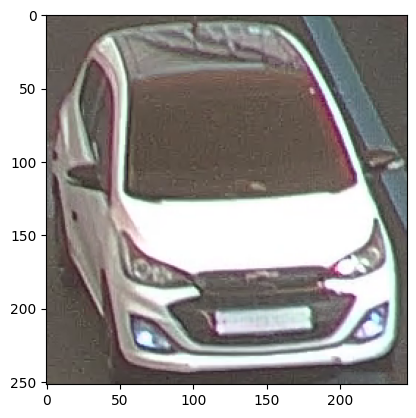

In [368]:
file_name = "155231127.png"
file_name = file_name.replace(".png", "_0.png")
file_path = f"/data/dacon_cars/data/test_cars_image/{file_name}"

plt.imshow(cv2.imread(file_path))

In [369]:
import shutil

shutil.copy(file_path, file_path.replace("test_cars_image", "new_spark"))

'/data/dacon_cars/data/new_spark/155231127_0.png'

In [9]:
# data.data[0].shape

with torch.no_grad():
    img_list = []
    for i in range(34):
        path_list = sorted(glob(f"/data/dacon_cars/data/train_cars_image/{i}/*.png"))[
            :100
        ]
        for path in tqdm(path_list):
            test_img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            test_img = test_transform(image=test_img)["image"]
            test_img = torch.Tensor(test_img).to(device, dtype=torch.float)
            test_img = torch.unsqueeze(test_img, 0)
            ensemble_probs = None
            for tta_model in model_list:
                probs = tta_model(test_img)
                probs = np.round(probs.cpu().detach().numpy(), 3)

            if ensemble_probs is None:
                ensemble_probs = probs
            else:
                ensemble_probs = ensemble_probs + probs

            ensemble_probs = np.round(ensemble_probs / len(model_list), 3)
            img_list.append(ensemble_probs)

    img_list

100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


In [10]:
img_array = np.array(img_list)

In [11]:
img_array = np.squeeze(img_array, axis=1)

In [12]:
img_array.shape

(3400, 34)

In [13]:
# data.data[0].shape

with torch.no_grad():
    spark_img_list = []

    path_list = sorted(glob(f"/data/dacon_cars/data/new_spark/*.png"))
    for path in tqdm(path_list):
        test_img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        test_img = test_transform(image=test_img)["image"]
        test_img = torch.Tensor(test_img).to(device, dtype=torch.float)
        test_img = torch.unsqueeze(test_img, 0)
        ensemble_probs = None
        for tta_model in model_list:
            probs = tta_model(test_img)
            probs = np.round(probs.cpu().detach().numpy(), 3)

        if ensemble_probs is None:
            ensemble_probs = probs
        else:
            ensemble_probs = ensemble_probs + probs

        ensemble_probs = np.round(ensemble_probs / len(model_list), 3)
        spark_img_list.append(ensemble_probs)

    spark_img_list

100%|██████████| 98/98 [00:22<00:00,  4.28it/s]


In [14]:
spark_img_array = np.array(spark_img_list)

In [15]:
spark_img_array = np.squeeze(spark_img_array, axis=1)
spark_img_array.shape

(98, 34)

In [16]:
total_img_array = np.concatenate([img_array, spark_img_array], axis=0)
total_img_array.shape

(3498, 34)

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca_result = pca.fit_transform(total_img_array)

<Figure size 640x480 with 0 Axes>

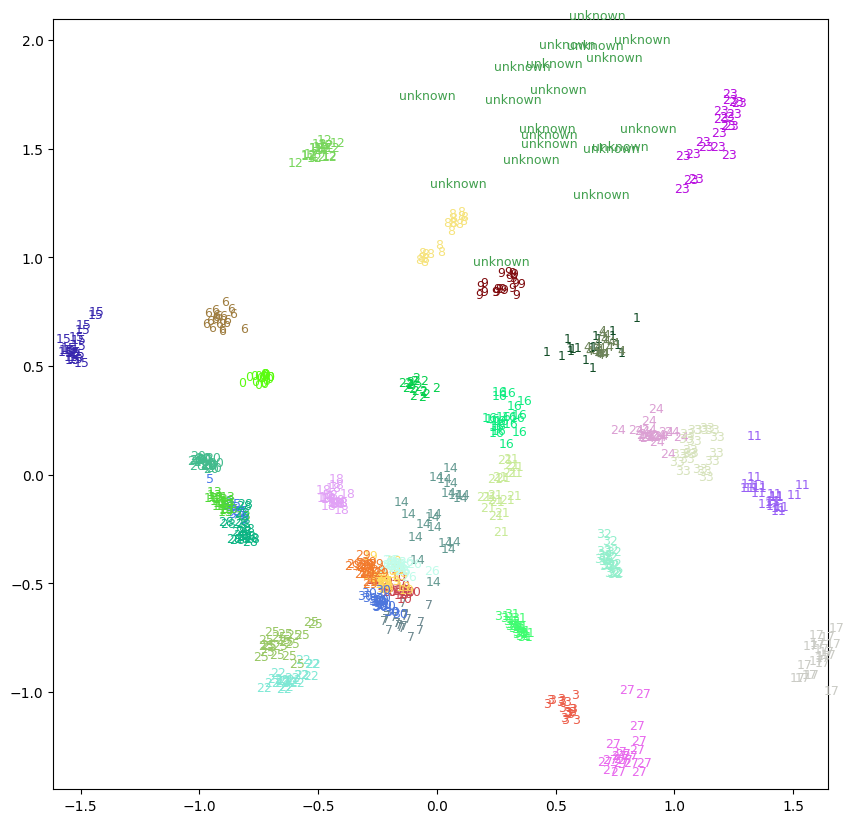

In [35]:
import random


def generate_random_hex():
    # 6자리 랜덤 hex 값 생성
    hex_value = "".join(random.choice("0123456789ABCDEF") for _ in range(6))
    return hex_value


plt.clf()
plt.figure(figsize=(10, 10))
plt.xlim(pca_result[:, 0].min(), pca_result[:, 0].max())
plt.ylim(pca_result[:, 1].min(), pca_result[:, 1].max())
for i in range(35):
    color = f"#{generate_random_hex()}"
    for j in range(20):
        if i == 34:
            plt.text(
                pca_result[i * 100 + j, 0],
                pca_result[i * 100 + j, 1],
                "unknown",
                color=color,
                fontdict={"size": 9},
            )
        else:
            plt.text(
                pca_result[i * 100 + j, 0],
                pca_result[i * 100 + j, 1],
                str(i),
                color=color,
                fontdict={"size": 9},
            )

        # plt.scatter(
        #     result[i * 100 : (i + 1) * 100, 0],
        #     result[i * 100 : (i + 1) * 100, 1],
        #     s=10,
        #     c=color,
        # )

plt.show()

In [36]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

# MNIST 데이터 불러오기
data = load_digits()

# t-sne 모델 생성
model = TSNE(n_components=2, perplexity=34, n_iter=1000, verbose=True, random_state=0)
# model = TSNE(n_components=2, perplexity=34, verbose=True, random_state=0)
# 학습한 결과 2차원 공간 값 출력
result = model.fit_transform(total_img_array)
# [
#     [67.38322, -1.9517338],
#     [-11.936052, -8.906425],
#     ...
#     [-10.278599, 8.832907],
#     [25.714725, 11.745557],
# ]
result

[t-SNE] Computing 103 nearest neighbors...
[t-SNE] Indexed 3498 samples in 0.001s...
[t-SNE] Computed neighbors for 3498 samples in 1.186s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3498
[t-SNE] Computed conditional probabilities for sample 2000 / 3498
[t-SNE] Computed conditional probabilities for sample 3000 / 3498
[t-SNE] Computed conditional probabilities for sample 3498 / 3498
[t-SNE] Mean sigma: 0.070425
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.435703
[t-SNE] KL divergence after 1000 iterations: 0.339613


array([[ 26.082726,  26.431345],
       [ 26.976835,  26.923323],
       [ 24.920824,  27.804298],
       ...,
       [ -9.229219,  49.11058 ],
       [ -7.54343 ,  48.860752],
       [-10.967016,  49.55742 ]], dtype=float32)

In [37]:
result.shape

(3498, 2)

<Figure size 640x480 with 0 Axes>

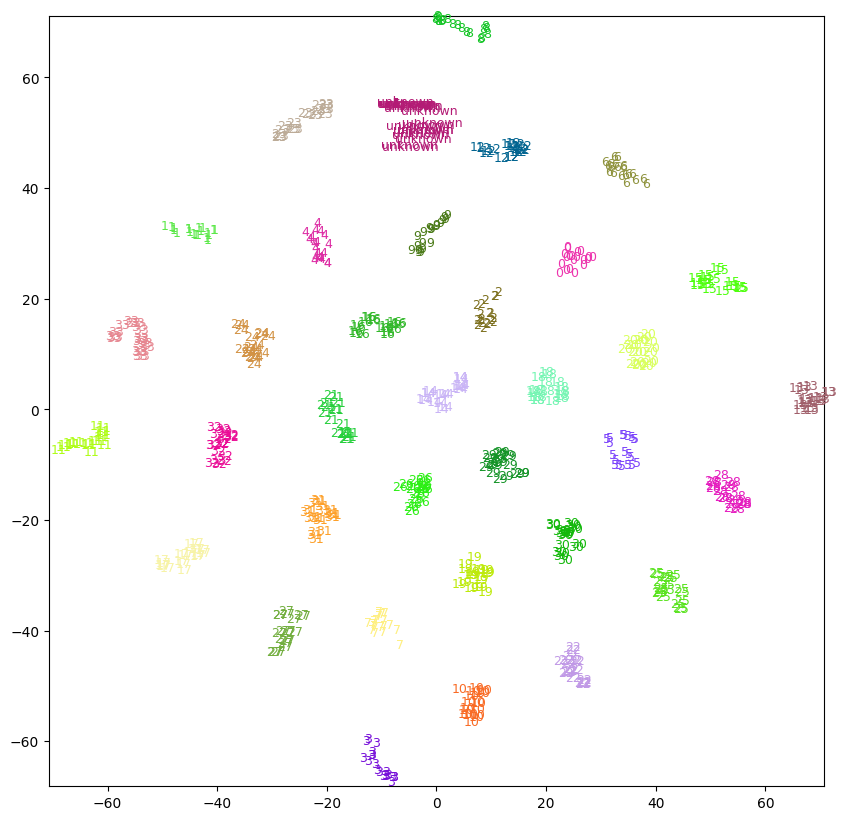

In [43]:
import random


def generate_random_hex():
    # 6자리 랜덤 hex 값 생성
    hex_value = "".join(random.choice("0123456789ABCDEF") for _ in range(6))
    return hex_value


plt.clf()
plt.figure(figsize=(10, 10))
plt.xlim(result[:, 0].min(), result[:, 0].max())
plt.ylim(result[:, 1].min(), result[:, 1].max())
for i in range(35):
    color = f"#{generate_random_hex()}"
    for j in range(20):
        if i == 34:
            plt.text(
                result[i * 100 + j, 0],
                result[i * 100 + j, 1],
                "unknown",
                color=color,
                fontdict={"size": 9},
            )
        else:
            plt.text(
                result[i * 100 + j, 0],
                result[i * 100 + j, 1],
                str(i),
                color=color,
                fontdict={"size": 9},
            )
        # plt.scatter(
        #     result[i * 100 : (i + 1) * 100, 0],
        #     result[i * 100 : (i + 1) * 100, 1],
        #     s=10,
        #     c=color,
        # )

plt.show()